In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
from scipy.spatial import distance
from sklearn.cluster import KMeans
from scipy.linalg import eig

#If you want to use the cells which call built-in SpectralClustering() function
#need the following two packages as well
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import SpectralClustering

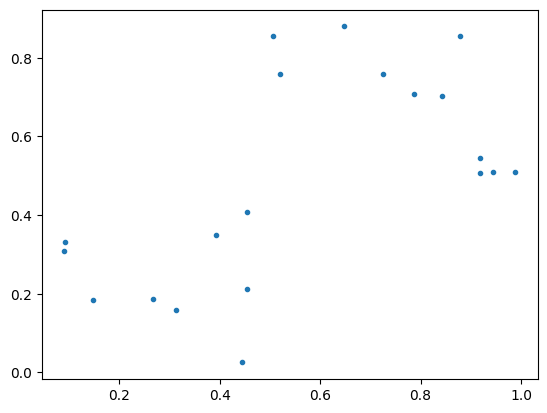

In [36]:
#True number of underlying clusters
d = 2 

#Assuming that each cluster is evenly spaced along the line y = x
partitions = list(np.linspace(0, 1, d + 1))

#True probability that the data is generated by each class
categorical_weights = random.uniform(0, 1, 2)
categorical_weights = categorical_weights/np.sum(categorical_weights)

x = []
y = []

N = 20 #Number of points, number of rows in matrices

#Generating sample points
for i in np.arange(N):
    #First determine which true cluster is generating the sample
    category_sample = random.uniform()
    temp = sorted(list(np.cumsum(categorical_weights)) + [category_sample])
    category_index = list(temp).index(category_sample)
    
    #Then generate the point
    x += [random.uniform(partitions[category_index], partitions[category_index + 1])]
    y += [random.uniform(partitions[category_index], partitions[category_index + 1])]     
    
plt.plot(x, y, '.')
samples = list(zip(x, y))

In [37]:
#Construct similarity matrix
N = len(samples)
sigma = 1 #Controls width of neighborhoods, set by user
k = 2 #Number of clusters, set by user
S = np.zeros((N, N))
for i in np.arange(N):
    for j in np.arange(N):
        S[i, j] += np.exp(-distance.euclidean(samples[i], samples[j])/(2*sigma**2))

In [38]:
diags = []
for i in np.arange(N):
    sum =0
    for j in np.arange(N):
        sum += np.sum(S[i, j])
    diags += [sum]
D = np.diag(diags)

In [33]:
#Unnormalized Grid Laplacian 
#This does not work as well as normalized
#Can run into problem of isolating a vertex
#L = D-S

#evals, evecs = eig(L)
#sorted_evals = sorted(evals)
#k_evals = []
#l = 0
#while len(k_evals) < k:
#    if sorted_evals[l] > 1e-10:
#        k_evals.append(sorted_evals[l])
#    l += 1

#V = np.zeros((N, k))

#i = 0
#for j in np.arange(len(evals)):
#    if evals[j] in k_evals:
#        V[:, i] = evecs[j]
#        i += 1


In [39]:
L = D-S
#Normalized Grid Laplacian
def generalized_eigenvectors(L, D, k):
    # Compute the generalized eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eig(L, D)

    # Sort eigenvalues and eigenvectors
    idx = np.argsort(eigenvalues.real)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Extract the first k eigenvectors
    first_k_eigenvectors = eigenvectors[:, :k]

    return first_k_eigenvectors
V = generalized_eigenvectors(L, D, k)

In [40]:
kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(V)

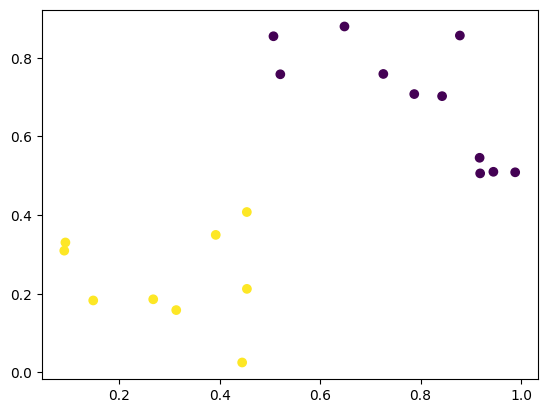

In [41]:
plt.scatter(x, y, c=kmeans.labels_)
plt.show()

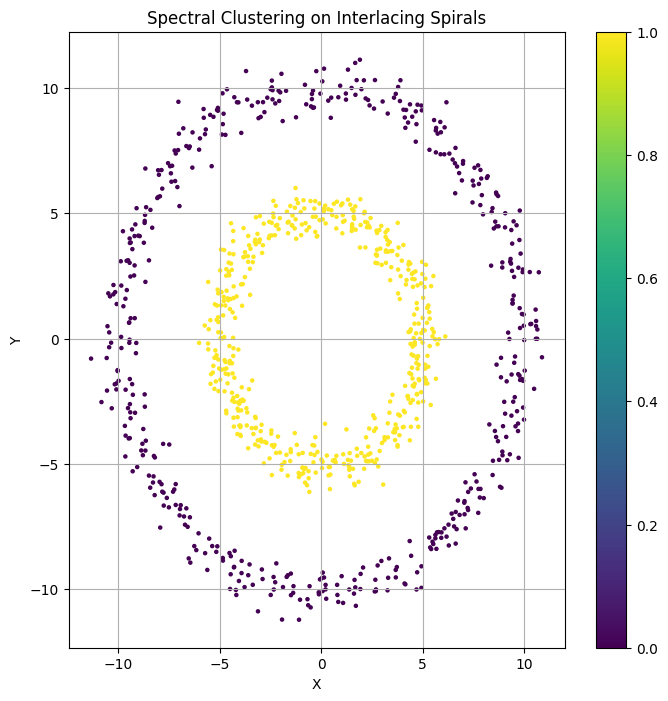

In [9]:
#Concentric circles problem
# Function to generate points for concentric circles with noise
def generate_concentric_circles_with_noise(num_points, inner_radius, outer_radius, noise_level):
    # Generate points for the inner circle
    theta_inner = np.linspace(0, 2 * np.pi, num_points)
    x_inner = inner_radius * np.cos(theta_inner)
    y_inner = inner_radius * np.sin(theta_inner)

    # Generate points for the outer circle
    theta_outer = np.linspace(0, 2 * np.pi, num_points)
    x_outer = outer_radius * np.cos(theta_outer)
    y_outer = outer_radius * np.sin(theta_outer)

    # Add noise to both sets of points
    x_inner += np.random.normal(0, noise_level, size=num_points)
    y_inner += np.random.normal(0, noise_level, size=num_points)
    x_outer += np.random.normal(0, noise_level, size=num_points)
    y_outer += np.random.normal(0, noise_level, size=num_points)

    return x_inner, y_inner, x_outer, y_outer

# Parameters for the circles
num_points = 500
inner_radius = 5
outer_radius = 10
noise_level = 0.5

# Generate concentric circles with noise
x_inner, y_inner, x_outer, y_outer = generate_concentric_circles_with_noise(num_points, inner_radius, outer_radius, noise_level)

# Combine the points
X = np.vstack((np.column_stack((x_inner, y_inner)), np.column_stack((x_outer, y_outer))))


#Perform spectral clustering using the built-in function SpectralClustering
# Compute pairwise distances between points
distances = euclidean_distances(X, X)

# Convert distances to similarity scores using Gaussian kernel
gamma = 1.0 / (2 * noise_level ** 2) #spectral clustering is quite sensitive to the sigma parameter, which is set at noise_level
similarity_matrix = np.exp(-gamma * distances ** 2)

# Perform spectral clustering
n_clusters = 2  # Number of clusters
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=0)
labels = spectral_clustering.fit_predict(similarity_matrix)

# Plot the points with cluster assignments
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
plt.title('Spectral Clustering on Interlacing Spirals')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.grid(True)
plt.show()

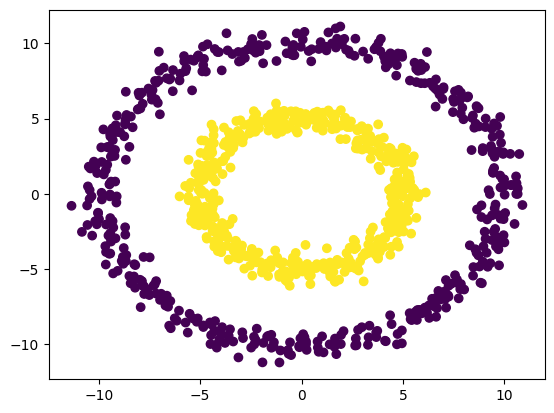

In [10]:
#Perform normalized spectral clustering on concentric circle problem
#Construct similarity matrix
N = np.shape(X)[0]
sigma = noise_level #Controls width of neighborhoods, set by user
k = 2 #Number of clusters, set by user
S = np.zeros((N, N))
for i in np.arange(N):
    for j in np.arange(N):
        S[i, j] += np.exp(-distance.euclidean(X[i], X[j])/(2*sigma**2))
diags = []
for i in np.arange(N):
    sum =0
    for j in np.arange(N):
        sum += np.sum(S[i, j])
    diags += [sum]
D = np.diag(diags)
L = D-S
#Normalized Grid Laplacian
def generalized_eigenvectors(L, D, k): 
    # Compute the generalized eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eig(L, D)

    # Sort eigenvalues and eigenvectors
    idx = np.argsort(eigenvalues.real)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Extract the first k eigenvectors
    first_k_eigenvectors = eigenvectors[:, :k]

    return first_k_eigenvectors
V = generalized_eigenvectors(L, D, k)

kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(V)

plt.scatter(X[:,0], X[:,1], c=kmeans.labels_)
plt.show()

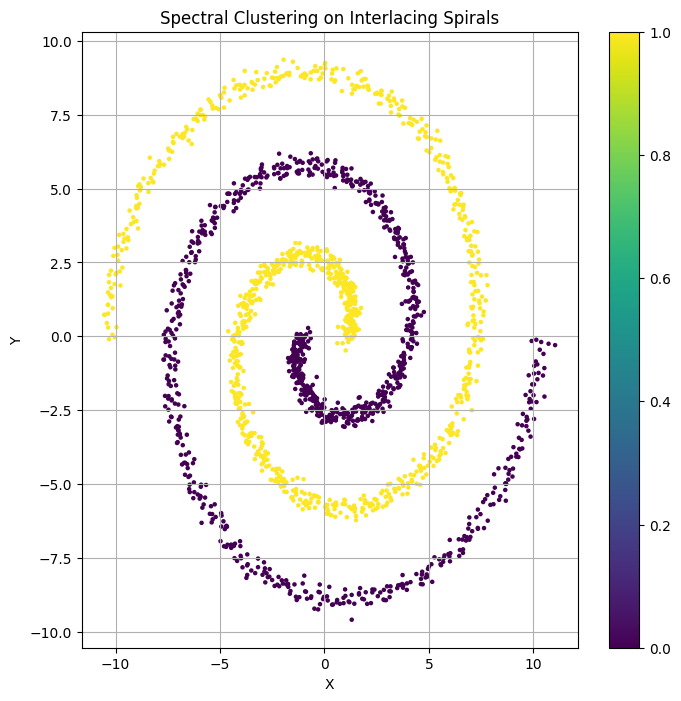

In [44]:
#Interlacing spirals problem
# Function to generate points for a spiral with added noise
def generate_spiral_points_with_noise(theta, a, b, offset, noise_level):
    x = (a + b * theta) * np.cos(theta + offset) + np.random.normal(0, noise_level, size=theta.shape)
    y = (a + b * theta) * np.sin(theta + offset) + np.random.normal(0, noise_level, size=theta.shape)
    return x, y

# Number of points for each spiral
num_points = 1000

# Parameters for the spirals
a = 1
b = 1

# Noise level: controls amount of noise added to spiral points
noise_level = 0.2

# Generate points for the first spiral with noise
theta1 = np.linspace(0, 3 * np.pi, num_points)
offset1 = 0
x1, y1 = generate_spiral_points_with_noise(theta1, a, b, offset1, noise_level)

# Generate points for the second spiral with noise
theta2 = np.linspace(0, 3 * np.pi, num_points)
offset2 = np.pi  # Offset by pi to interlace the spirals
x2, y2 = generate_spiral_points_with_noise(theta2, a, b, offset2, noise_level)

# Combine the points
X = np.vstack((np.column_stack((x1, y1)), np.column_stack((x2, y2))))

#Perform spectral clustering using the built-in function SpectralClustering
# Compute pairwise distances between points
distances = euclidean_distances(X, X)

# Convert distances to similarity scores using Gaussian kernel
gamma = 1.0/(2 * noise_level ** 2)
similarity_matrix = np.exp(-gamma * distances ** 2)  #spectral clustering is quite sensitive to the sigma parameter, which is set at noise_level

# Perform spectral clustering
n_clusters = 2  # Number of clusters
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=0)
labels = spectral_clustering.fit_predict(similarity_matrix)

# Plot the points with cluster assignments
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
plt.title('Spectral Clustering on Interlacing Spirals')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.grid(True)
plt.show()

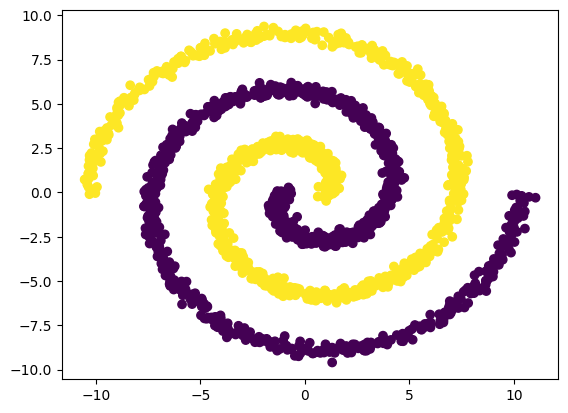

In [45]:
#CAUTION: normalized spectral clustering without the use of SpectralClustering function takes a long time to run
#Perform normalized spectral clustering on interlacing spirals problem
#Construct similarity matrix
N = np.shape(X)[0]
sigma = noise_level #Controls width of neighborhoods, set by user
k = 2 #Number of clusters, set by user
S = np.zeros((N, N))
for i in np.arange(N):
    for j in np.arange(N):
        S[i, j] += np.exp(-distance.euclidean(X[i], X[j])/(2*sigma**2))
diags = []
for i in np.arange(N):
    sum =0
    for j in np.arange(N):
        sum += np.sum(S[i, j])
    diags += [sum]
D = np.diag(diags)
L = D-S
#Normalized Grid Laplacian
#The following function was scripted by ChatGPT
def generalized_eigenvectors(L, D, k): 
    # Compute the generalized eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eig(L, D)

    # Sort eigenvalues and eigenvectors
    idx = np.argsort(eigenvalues.real)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Extract the first k eigenvectors
    first_k_eigenvectors = eigenvectors[:, :k]

    return first_k_eigenvectors
V = generalized_eigenvectors(L, D, k)

kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(V)

plt.scatter(X[:,0], X[:,1], c=kmeans.labels_)
plt.show()